In [ ]:
# Import necessary modules first.
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
#load the dataset
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/age detection/archive.zip'

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [ ]:
BASE_DIR = '/content/UTKFace'
age_labels = []
gender_labels = []
image_paths = []

image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
  image_path = os.path.join(BASE_DIR, image)
  img_components = image.split('_')
  age_label = int(img_components[0])
  gender_label = int(img_components[1])

  # Append the image_path, age_label, and gender_label
  age_labels.append(age_label)
  gender_labels.append(gender_label)
  image_paths.append(image_path)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
print(f'Number of age_labels: {len(age_labels)}, Number of gender_labels: {len(gender_labels)}, Number of image_paths: {len(image_paths)}')

Number of age_labels: 23708, Number of gender_labels: 23708, Number of image_paths: 23708


In [ ]:
gender_mapping = {
    1: 'Female',
    0: 'Male'
}

In [ ]:
import pandas as pd
df = pd.DataFrame()
df['image_path'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head(5)

,image_path,age,gender
0,/content/UTKFace/24_0_2_20170116173527524.jpg....,24,0
1,/content/UTKFace/1_0_0_20170103210415090.jpg.c...,1,0
2,/content/UTKFace/36_0_3_20170119183543230.jpg....,36,0
3,/content/UTKFace/17_1_1_20170112230710598.jpg....,17,1
4,/content/UTKFace/36_0_0_20170116011210805.jpg....,36,0


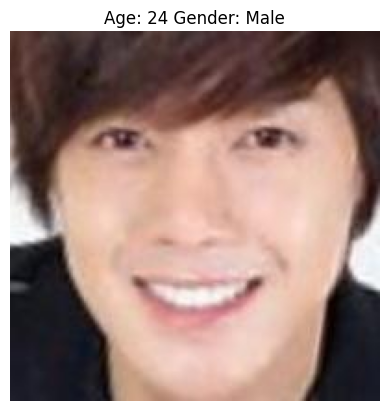

In [ ]:
from PIL import Image

rand_index = random.randint(0, len(image_paths))
age = df['age'][rand_index]
gender = df['gender'][rand_index]
IMG = Image.open(df['image_path'][rand_index])
plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
plt.axis('off')
plt.imshow(IMG)

<Axes: xlabel='age', ylabel='Density'>

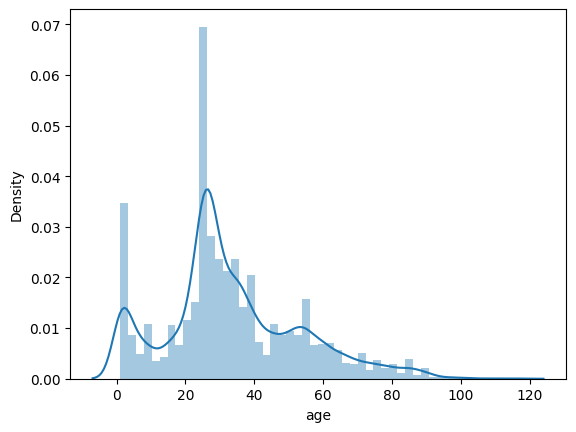

In [ ]:
 # Age distribution
 sns.distplot(df['age'])

<Axes: ylabel='count'>

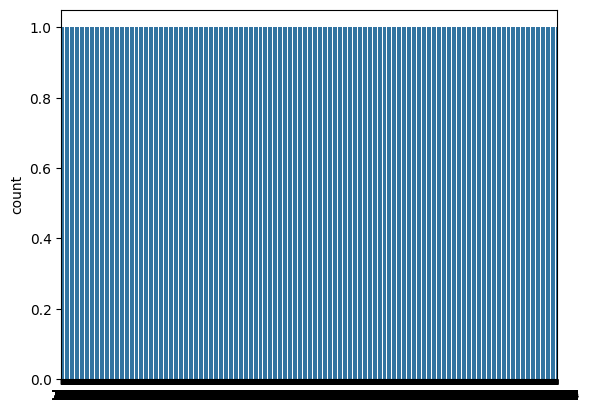

In [ ]:
sns.countplot(df['gender'])

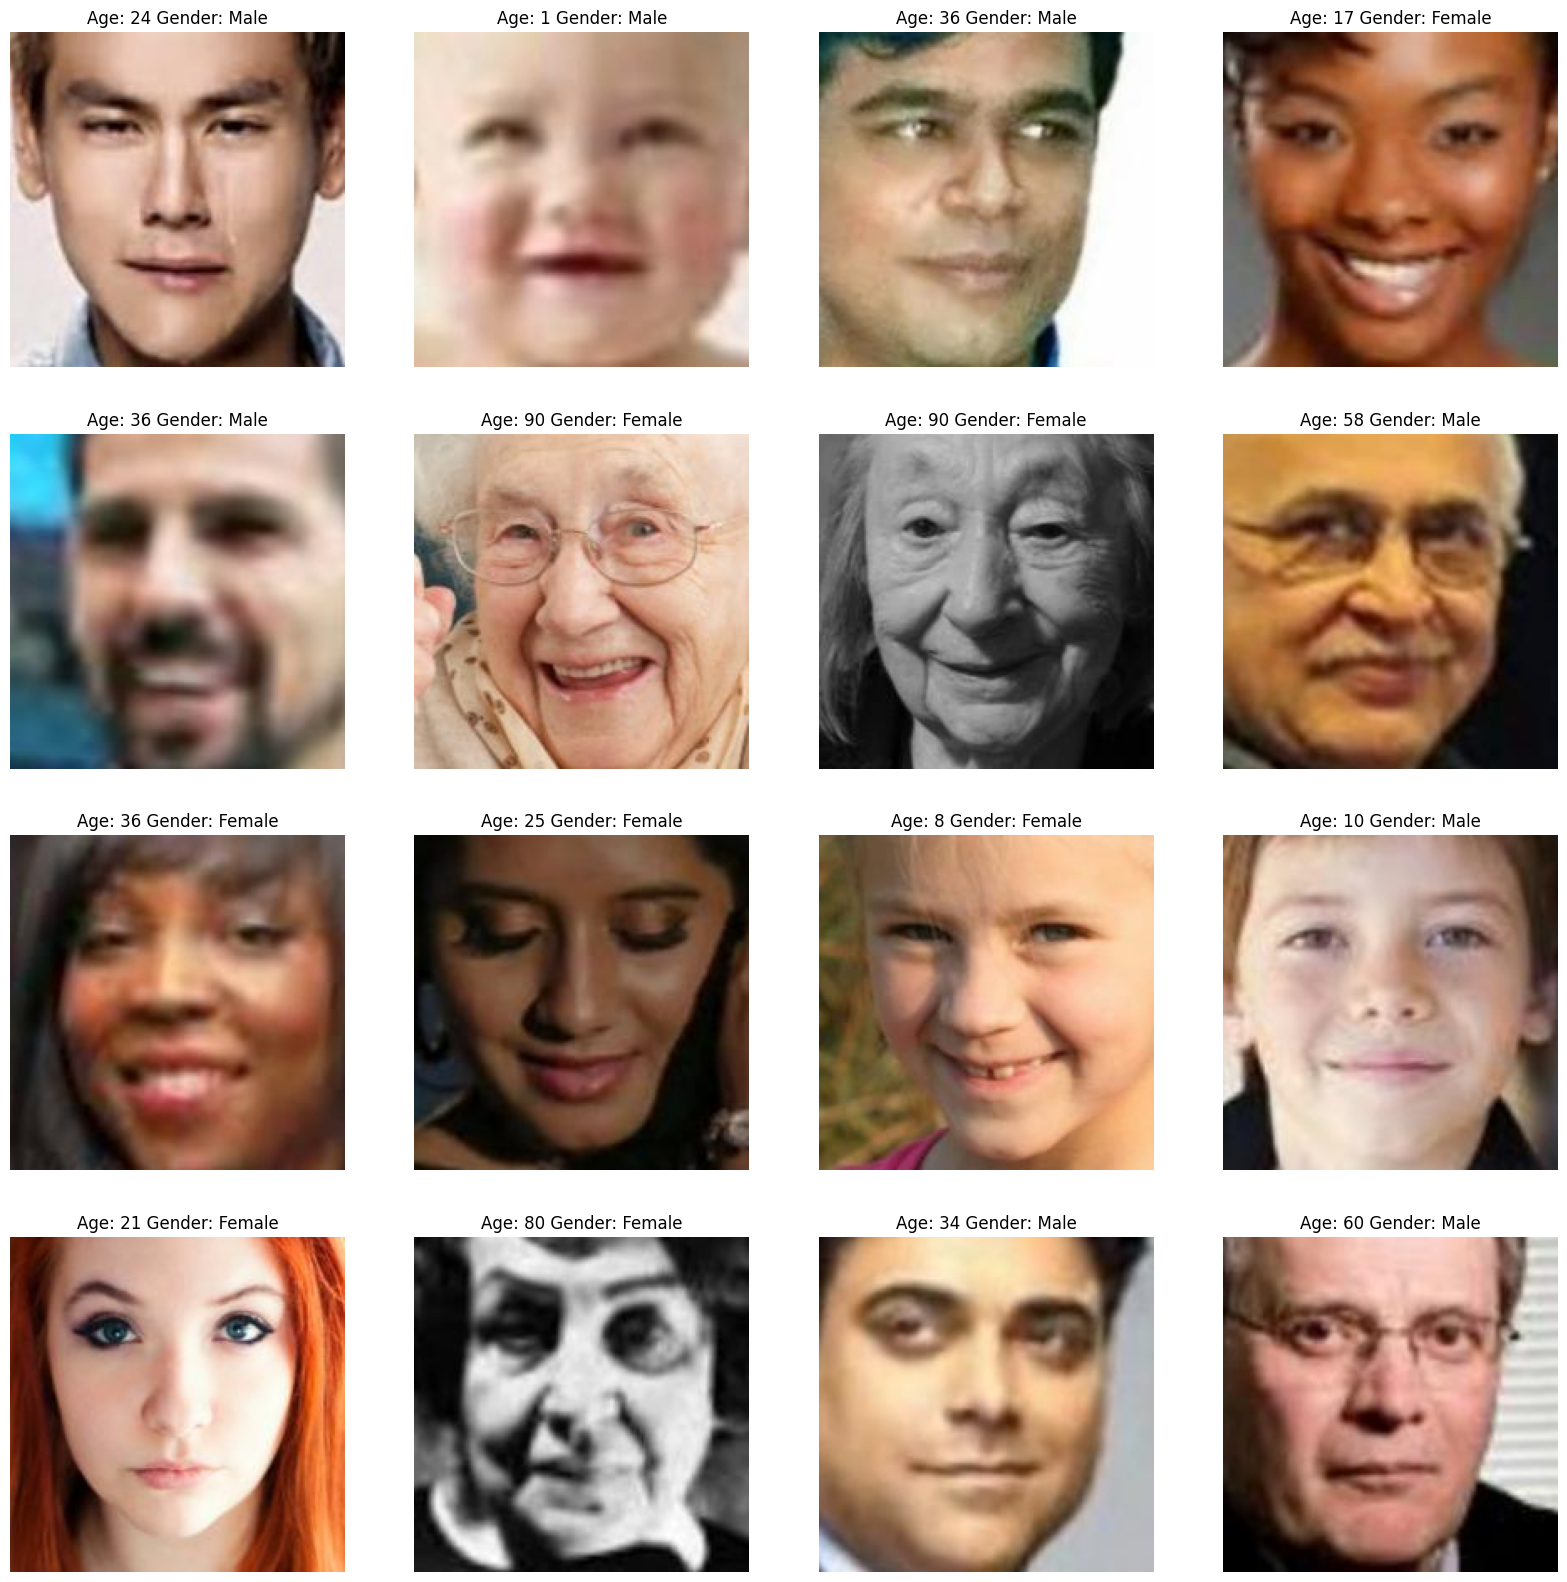

In [ ]:
plt.figure(figsize=(20, 20))
samples = df.iloc[0:16]

for index, sample, age, gender in samples.itertuples():
    plt.subplot(4, 4, index + 1)
    img = load_img(sample)
    img = np.array(img)
    plt.axis('off')
    plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
    plt.imshow(img)

In [ ]:
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tqdm import tqdm
import numpy as np
from PIL import Image

#feature extraction
def extract_image_features(images):
    features = list()

    for image in tqdm(images):
        # Load the image using Keras' load_img function, converting to grayscale
        img = load_img(image, color_mode='grayscale')
        # Resize the image for consistency
        img = img.resize((128, 128), Image.ANTIALIAS)
        # Convert the image to a NumPy array for processing
        img = img_to_array(img)
        features.append(img)

    features = np.array(features)
    # Reshape to fit the expected input format for most image processing models
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [ ]:
X = extract_image_features(df['image_path'])

100%|██████████| 23708/23708 [00:30<00:00, 779.08it/s]


In [ ]:
X.shape

(23708, 128, 128, 1)

In [ ]:
X = X / 255.0

In [ ]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [ ]:
input_shape = (128, 128, 1)

In [ ]:
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

# fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam', metrics=['accuracy'])

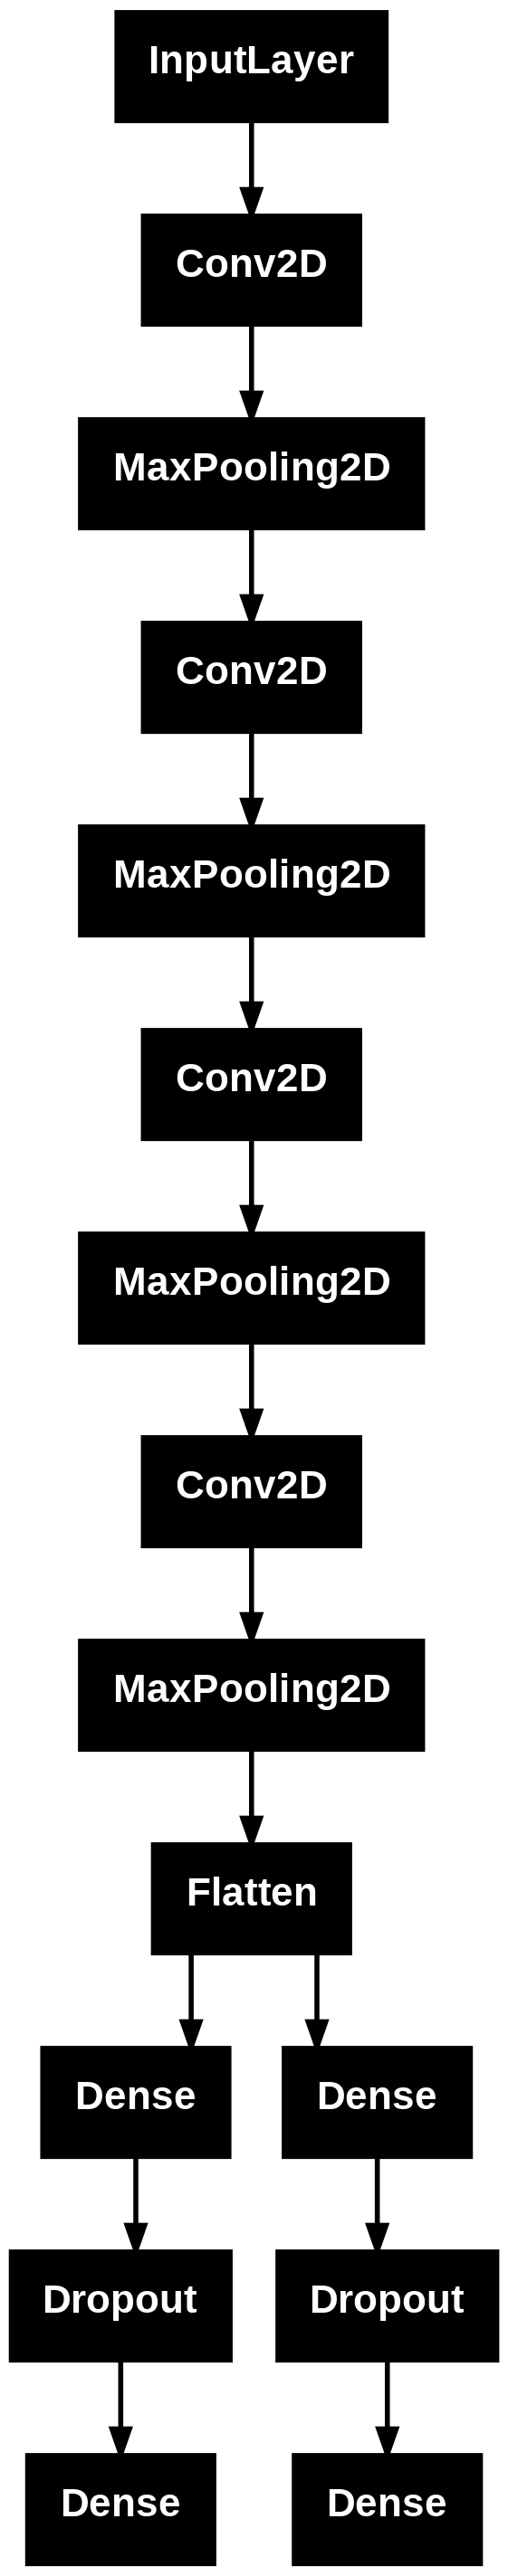

In [ ]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam',
              metrics={'gender_out':'accuracy', 'age_out':'mae'}) # Specify metrics for each output

In [ ]:
history = model.fit(x=X, y=[y_gender, y_age],
                    batch_size=32, epochs=50, validation_split=0.2)

Epoch 1/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 30s 36ms/step - age_out_mae: 15.9060 - gender_out_accuracy: 0.5346 - loss: 16.6033 - val_age_out_mae: 10.6826 - val_gender_out_accuracy: 0.7402 - val_loss: 11.1926
Epoch 2/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - age_out_mae: 11.1101 - gender_out_accuracy: 0.7659 - loss: 11.6010 - val_age_out_mae: 8.7643 - val_gender_out_accuracy: 0.8060 - val_loss: 9.1831
Epoch 3/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - age_out_mae: 9.4834 - gender_out_accuracy: 0.8025 - loss: 9.9101 - val_age_out_mae: 8.1062 - val_gender_out_accuracy: 0.8195 - val_loss: 8.4898
Epoch 4/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - age_out_mae: 8.3724 - gender_out_accuracy: 0.8281 - loss: 8.7444 - val_age_out_mae: 7.5740 - val_gender_out_accuracy: 0.8469 - val_loss: 7.9124
Epoch 5/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - age_out_mae: 7.8886 - gender_out_accuracy: 0.8405 - loss: 8.2300 - val_age_out_mae: 7.0769 - val_gender_out_accuracy: 0.8650 - val_loss: 7

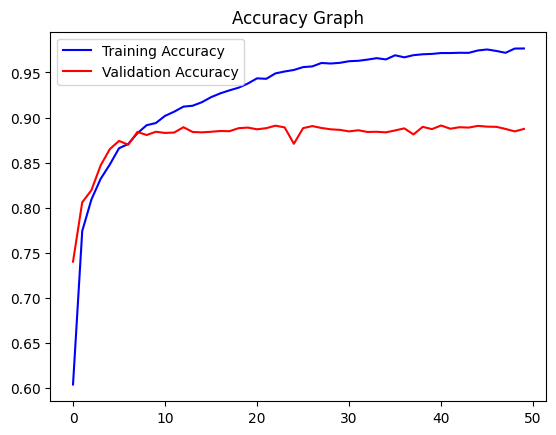

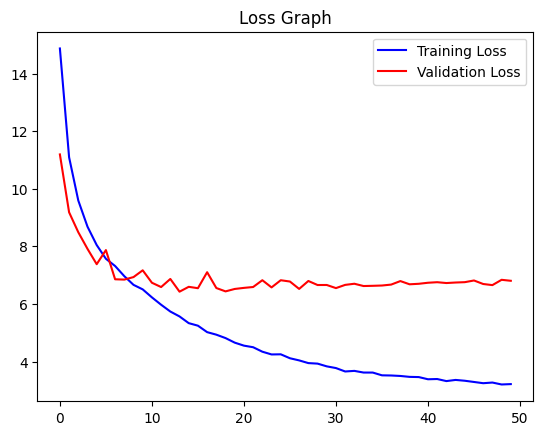

In [ ]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

# Access the overall loss (since individual losses weren't tracked separately)
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

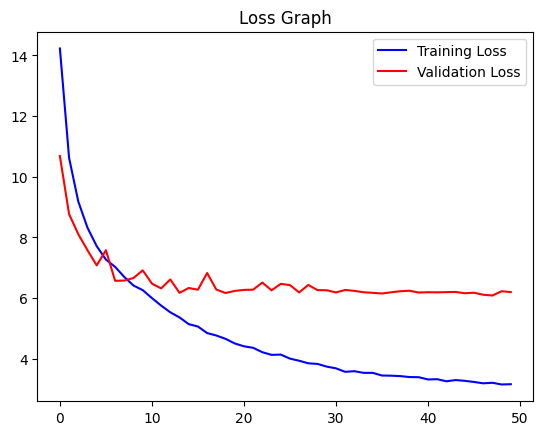

In [ ]:
# plot results for age
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [ ]:
#practising test data
#practising test data
def get_image_features(image):
  img = load_img(image, color_mode='grayscale') # Use color_mode='grayscale' instead of grayscale=True
  img = img.resize((128, 128), Image.ANTIALIAS)
  img = img_to_array(img) # Convert the image to a NumPy array
  img = img.reshape(1, 128, 128, 1)
  img = img / 255.0
  return img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


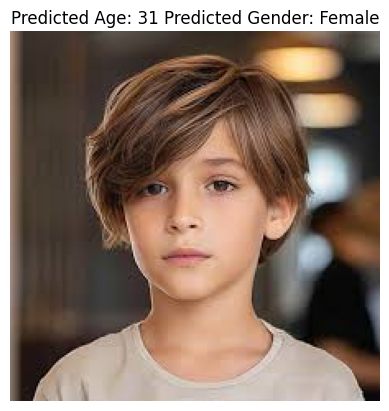

In [ ]:
img_to_test = '/content/test_images/boy.jpg'
features = get_image_features(img_to_test)
pred = model.predict(features)
gender = gender_mapping[round(pred[0][0][0])]
age = round(pred[1][0][0])

plt.title(f'Predicted Age: {age} Predicted Gender: {gender}')
plt.axis('off')
plt.imshow(np.array(load_img(img_to_test)))

In [ ]:
import requests
from bs4 import BeautifulSoup
import os

# URL of the GitHub directory
url = "https://github.com/ammarlodhi255/codeclause_projects/tree/main/Age%20and%20Gender%20Detection%20System/test%20images"

# Get the HTML content of the page
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Create a directory to save the images
os.makedirs("test_images", exist_ok=True)

# Find all image links on the page
for link in soup.find_all('a', href=True):
    file_name = link['href'].split('/')[-1]
    if file_name.endswith(('.jpg', '.png', '.jpeg')):
        # Construct the download URL
        download_url = f"https://raw.githubusercontent.com/ammarlodhi255/codeclause_projects/main/Age%20and%20Gender%20Detection%20System/test%20images/{file_name}"

        # Download the image
        img_data = requests.get(download_url).content
        with open(os.path.join("test_images", file_name), 'wb') as handler:
            handler.write(img_data)
        print(f"Downloaded: {file_name}")


Downloaded: 1.png
Downloaded: 1.png
Downloaded: 2.png
Downloaded: 2.png
Downloaded: 3.png
Downloaded: 3.png
Downloaded: 4.png
Downloaded: 4.png


In [ ]:
# Assuming you have your entire dataset in 'X' and labels in 'y_gender' and 'y_age'
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_gender_train, y_gender_test, y_age_train, y_age_test = train_test_split(
    X, y_gender, y_age, test_size=0.2, random_state=42  # Adjust test_size and random_state as needed
)

# Now you can evaluate the model
results = model.evaluate(X_test, [y_gender_test, y_age_test], batch_size=32)

# ... rest of your code ...

# Extracting the loss and accuracy
loss = results[0]  # Total loss
gender_accuracy = results[1] * 100  # Gender accuracy in percentage
age_mae = results[2]  # Mean Absolute Error for age

print(f"Test Loss: {loss:.4f}")
print(f"Test Gender Prediction Accuracy: {gender_accuracy:.2f}%")
print(f"Test Age Prediction MAE: {age_mae:.2f} years")



149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - age_out_mae: 3.2800 - gender_out_accuracy: 0.9681 - loss: 3.4249
Test Loss: 3.4899
Test Gender Prediction Accuracy: 333.55%
Test Age Prediction MAE: 0.97 years


In [ ]:
# Save the model
model_name = "model.h5"
model.save(model_name)

print(f"Model saved as {model_name}")


Model saved as model.h5


SyntaxError: invalid syntax (<ipython-input-43-edfc42f4c302>, line 6)